In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm

## Load data and separate train from test-phase

There are cases where load and temp data are missing due to a blackout (see Known_Artifacts.md for an inexhaustive list)

We need to impute the temperature data to use it for training ARIMA-type models. We did NOT need this for the univariate model since complete data is only assumed for covariate (not the outcome).

In [2]:
base_data = pd.read_csv('data.csv', index_col=0)
base_data.index = pd.to_datetime(base_data.index)
base_data = base_data.asfreq('H')

imputed_data = base_data.copy()
for idx, row in imputed_data.iterrows():
    if np.isnan(row.tmp_f_KDFW):
        imputed_data.loc[idx].tmp_f_KDFW = base_data[
                                                    (base_data.index.month == idx.month) & 
                                                    (base_data.index.day == idx.day) & 
                                                    (base_data.index.hour == idx.hour)
                                                ].tmp_f_KDFW.mean()

In [3]:
train_data = imputed_data[imputed_data.index < '2021-07-01']
train_data = train_data.asfreq('H')
target_data = imputed_data[imputed_data.index >= '2021-07-01']
target_data = target_data.asfreq('H')

# First Pass

## AR(1) Model

Since we're going to have temperature data included, we can likely reduce the number of parameters (reduce overfitting) and stop using the moving average and integration components

In [4]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(1, 0, 0), trend='t')

# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            4     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.93256D+00    |proj g|=  1.44620D-02


 This problem is unconstrained.



At iterate    5    f=  7.90793D+00    |proj g|=  2.29256D+00

At iterate   10    f=  7.90447D+00    |proj g|=  9.73477D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    4     10     25      1     0     0   9.735D-04   7.904D+00
  F =   7.9044711227925415     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:               SARIMAX(1, 0, 0)   Log Likelihood             -311499.398
Date:                Wed, 22 Jun 2022   AIC                   

### Get Results Through 10/31/21

In [5]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  16402.516478    717.186443   15222.849756   
2021-07-01 01:00:00-06:00  16346.700054   1013.146651   14680.222111   
2021-07-01 02:00:00-06:00  16212.844261   1239.491444   14174.062263   
2021-07-01 03:00:00-06:00  16104.975560   1429.679991   13753.361242   
2021-07-01 04:00:00-06:00  16062.103901   1596.688251   13435.785440   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  19524.267580  10851.649122    1674.893163   
2021-10-31 20:00:00-06:00  19186.451575  10851.649181    1337.077060   
2021-10-31 21:00:00-06:00  18809.625630  10851.649240     960.251020   
2021-10-31 22:00:00-06:00  18393.789748  10851.649298     544.415041   
2021-10-31 23:00:00-06:00  18173.003372  10851.649356     323.628569   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   17582.183199  
2021-07-01 01:00:00-06:00   18013.177998  
2021-0

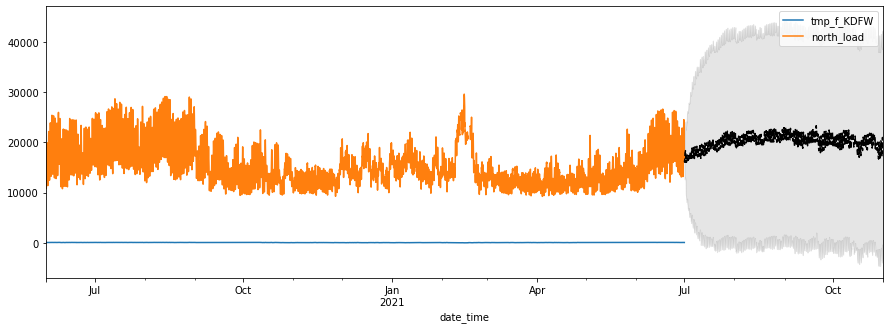

In [6]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2020-06-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## AR(12) Model

Perhaps we can't actually reduce the number of parameters...

In [8]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(12, 0, 0), trend='t')

# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           15     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.33757D+00    |proj g|=  5.21771D-02


 This problem is unconstrained.



At iterate    5    f=  7.33409D+00    |proj g|=  7.47058D-03

At iterate   10    f=  7.33385D+00    |proj g|=  6.85394D-03

At iterate   15    f=  7.33250D+00    |proj g|=  1.28993D-01

At iterate   20    f=  7.28745D+00    |proj g|=  3.02772D-01

At iterate   25    f=  7.14838D+00    |proj g|=  8.29435D-01

At iterate   30    f=  7.11704D+00    |proj g|=  4.75341D-01

At iterate   35    f=  7.09439D+00    |proj g|=  1.29468D+00

At iterate   40    f=  7.09337D+00    |proj g|=  4.66061D-01

At iterate   45    f=  7.08740D+00    |proj g|=  1.74906D-01


/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.08685D+00    |proj g|=  3.90799D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   15     50     62      1     0     0   3.908D-01   7.087D+00
  F =   7.0868452120016006     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(12, 0, 0)   Log Likelihood             -279278.396
Date:                Wed, 22 Jun 2022   AIC                         558586.792
Time:                        08:54:47   BIC  

### Get Results Through 10/31/21

In [9]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  14875.036877    374.276618   14259.406624   
2021-07-01 01:00:00-06:00  13869.723221    922.401459   12352.507836   
2021-07-01 02:00:00-06:00  13387.266862   1498.212591   10922.926447   
2021-07-01 03:00:00-06:00  13306.516321   2054.304721    9927.485750   
2021-07-01 04:00:00-06:00  13591.334815   2580.952398    9346.045902   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  36942.522064  24118.903669   -2729.544114   
2021-10-31 20:00:00-06:00  36996.367634  24119.295504   -2676.343056   
2021-10-31 21:00:00-06:00  37056.088926  24119.686849   -2617.265468   
2021-10-31 22:00:00-06:00  37121.685940  24120.077702   -2552.311351   
2021-10-31 23:00:00-06:00  37157.897299  24120.468066   -2516.742083   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15490.667130  
2021-07-01 01:00:00-06:00   15386.938607  
2021-0

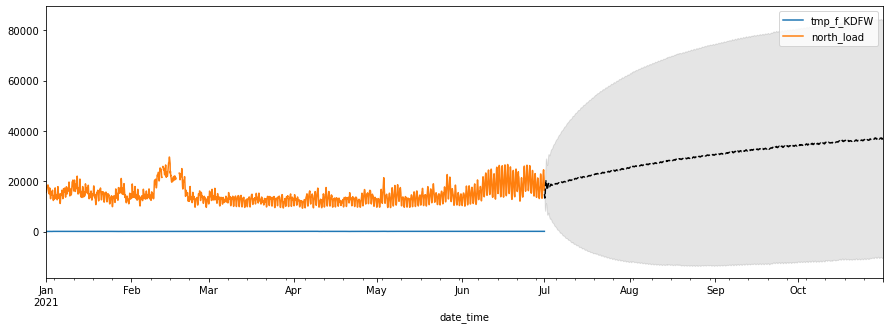

In [10]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## AR(24) Model

In [11]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 0, 0), trend='t')

# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           27     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.16287D+00    |proj g|=  6.69498D-02


 This problem is unconstrained.



At iterate    5    f=  7.16028D+00    |proj g|=  1.02207D-01

At iterate   10    f=  7.15946D+00    |proj g|=  4.72034D-02

At iterate   15    f=  7.15934D+00    |proj g|=  2.02799D-02

At iterate   20    f=  7.15929D+00    |proj g|=  5.98435D-03

At iterate   25    f=  7.15924D+00    |proj g|=  2.78459D-03

At iterate   30    f=  7.15911D+00    |proj g|=  8.48448D-03

At iterate   35    f=  7.15904D+00    |proj g|=  3.52669D-02

At iterate   40    f=  7.15898D+00    |proj g|=  7.49448D-03

At iterate   45    f=  7.15881D+00    |proj g|=  6.19642D-02


/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  7.15832D+00    |proj g|=  1.82477D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   27     50     60      1     0     0   1.825D-02   7.158D+00
  F =   7.1583194466027589     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(24, 0, 0)   Log Likelihood             -282095.053
Date:                Wed, 22 Jun 2022   AIC                         564244.106
Time:                        09:24:29   BIC  

### Get Results Through 10/31/21

In [12]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean      mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  15139.139650   353.991511   14556.875430   
2021-07-01 01:00:00-06:00  14327.422661   741.618673   13107.568497   
2021-07-01 02:00:00-06:00  13739.240644  1059.412879   11996.661528   
2021-07-01 03:00:00-06:00  13592.290846  1319.906533   11421.237798   
2021-07-01 04:00:00-06:00  13874.603693  1537.357478   11345.875669   
...                                 ...          ...            ...   
2021-10-31 19:00:00-06:00  16274.420926  4886.358704    8237.076089   
2021-10-31 20:00:00-06:00  15704.526388  4886.358704    7667.181551   
2021-10-31 21:00:00-06:00  15068.871158  4886.358704    7031.526321   
2021-10-31 22:00:00-06:00  14367.455284  4886.358704    6330.110447   
2021-10-31 23:00:00-06:00  13994.843717  4886.358704    5957.498881   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15721.403871  
2021-07-01 01:00:00-06:00   15547.276825  
2021-07-01 02:00:0

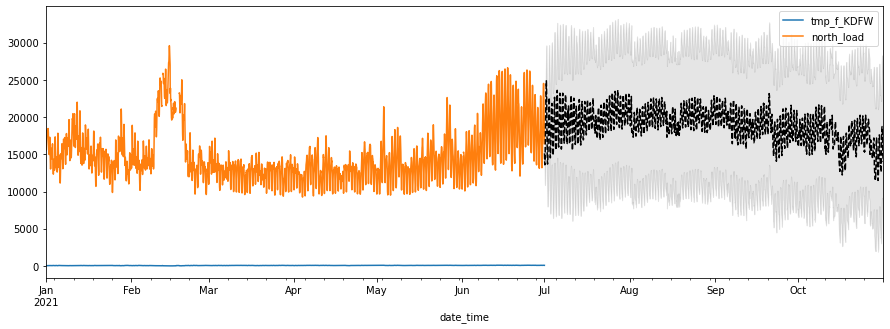

In [13]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.loc['2021-01-01':].plot(ax=ax)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

The above looks pretty reasonable aside from the fact that the uncertainty estimates are constant over time. We'd expect uncertainty to _grow_ further into the forecast window.

## ARIMA(24, 1, 8) Model

In [14]:
# Construct the model
mod = sm.tsa.SARIMAX(endog=train_data.north_load, exog=train_data.tmp_f_KDFW, order=(24, 1, 8), trend='c')

# Estimate the parameters
res = mod.fit()

print(res.summary())

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =           35     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.92353D+00    |proj g|=  2.86071D-01


 This problem is unconstrained.



At iterate    5    f=  6.86219D+00    |proj g|=  8.80763D-02

At iterate   10    f=  6.84473D+00    |proj g|=  3.13738D-02

At iterate   15    f=  6.84157D+00    |proj g|=  3.48006D-02

At iterate   20    f=  6.83892D+00    |proj g|=  1.64414D-02

At iterate   25    f=  6.83780D+00    |proj g|=  1.12994D-02

At iterate   30    f=  6.83722D+00    |proj g|=  8.25476D-03

At iterate   35    f=  6.83708D+00    |proj g|=  2.72937D-03

At iterate   40    f=  6.83688D+00    |proj g|=  1.28514D-02

At iterate   45    f=  6.83647D+00    |proj g|=  4.30399D-03


/home/esherma9/miniconda3/envs/NT_Demand/lib/python3.9/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "



At iterate   50    f=  6.83627D+00    |proj g|=  7.87154D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
   35     50     57      1     0     0   7.872D-03   6.836D+00
  F =   6.8362661367804707     

STOP: TOTAL NO. of ITERATIONS REACHED LIMIT                 
                               SARIMAX Results                                
Dep. Variable:             north_load   No. Observations:                39408
Model:              SARIMAX(24, 1, 8)   Log Likelihood             -269403.576
Date:                Wed, 22 Jun 2022   AIC                         538877.152
Time:                        09:40:12   BIC  

### Get Results Through 10/31/21

In [15]:
# Here we construct a more complete results object.
fcast_res1 = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:])

# Most results are collected in the `summary_frame` attribute.
# Here we specify that we want a confidence level of 90%
print(fcast_res1.summary_frame(alpha=0.10))

north_load                         mean       mean_se  mean_ci_lower  \
2021-07-01 00:00:00-06:00  15089.401109    260.668409   14660.639731   
2021-07-01 01:00:00-06:00  14217.561193    556.762406   13301.768529   
2021-07-01 02:00:00-06:00  13603.844625    824.790111   12247.185620   
2021-07-01 03:00:00-06:00  13409.323433   1066.077306   11655.782309   
2021-07-01 04:00:00-06:00  13736.552848   1279.478025   11631.998778   
...                                 ...           ...            ...   
2021-10-31 19:00:00-06:00  16862.213039  27633.332347  -28590.573896   
2021-10-31 20:00:00-06:00  16566.655717  27637.984176  -28893.782796   
2021-10-31 21:00:00-06:00  16229.405679  27642.593072  -29238.613794   
2021-10-31 22:00:00-06:00  15847.992923  27647.157870  -29627.534975   
2021-10-31 23:00:00-06:00  15652.068952  27651.680382  -29830.897816   

north_load                 mean_ci_upper  
2021-07-01 00:00:00-06:00   15518.162488  
2021-07-01 01:00:00-06:00   15133.353856  
2021-0

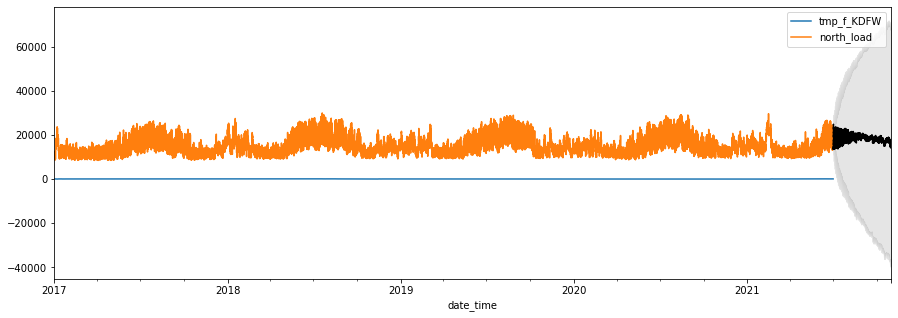

In [16]:
fig, ax = plt.subplots(figsize=(15, 5))

# Plot the data (here we are subsetting it to get a better look at the forecasts)
train_data.plot(ax=ax, legend=True)
# train_data.tmp_f_KDFW.loc['2020-01-01':].plot(ax=ax, secondary_y=True, legend=True)

# Construct the forecasts
fcast = res.get_forecast(target_data.index[-1], exog=target_data.tmp_f_KDFW[:]).summary_frame()
fcast['mean'].plot(ax=ax, style='k--')
ax.fill_between(fcast.index, fcast['mean_ci_lower'], fcast['mean_ci_upper'], color='k', alpha=0.1);

## Analysis to Here

We are getting something that looks better on point estimates. We are getting good daily behavior (at least in the early forecasts) and a slightly increasing trend into late summer and then a decreasing trend as we hit fall.

This is imperfect, though. The daily trend is decaying a bit (likely because integration component is taking over from AR(24) component. Additionally, the variance is blowing up to unreasonable levels (e.g. forecasted negative load). My suspicion is that the model is not paying enough attention to the exogenous (weather) variables, which can be accounted for by standardizing each series individually.